<h2><font color="gray">Muhammet Eren KÜÇÜK</font></center></h2>


<h1 style="color: firebrick; font-family: verdana"><b>Problem Definition</b></h1>

<p style="font-family: verdana"><b>Neural networks</b> are algorithms created explicitly to simulate biological neural networks. Neural networks are modeled after the human brain, as the main idea behind neural networks is to make a machine think like a human. A neural network consists of interconnected <b>neurons</b> that maintain the information flow in the system.</p>

<p style="font-family: verdana">In image recognition applications, a regular (fully connected) neural network is not preferred due to the large amounts of neurons necessary to build the network, and the fact that objects tend to have different transformations in different images. The same neural network model might not observe the same objects as included in the same class. Instead of gathering each pixel of the image to classify an object, we simply can <b>extract abstract features that're useful for classification from the object</b>. For instance, if we want an object to be classify as a bird; we can extract features like claws, wings and beak for classification, instead of checking every single pixel. This is done by building <b>convolutional neural networks (CNNs)</b>.</p>

<p style="font-family: verdana">For our assignment, we have a dataset that consists of approximately <b>20,000 vegetable images</b>. About 15,000 of these images are under the train subset, while 3,000 images each are assigned for the validation and test subsets. These images belong to <b>15 classes (species) of vegetables</b>. Our objective is to design two types of neural networks to classify the vegetable objects in these images.</p>

<p style="font-family: verdana">In Part 1, we'll implement a <b>single layer neural network</b> and observe the results in different parameters. Then, we'll implement a <b>neural network with one hidden layer</b>. Finally, we need to implement another <b>neural network with two hidden layers</b> and report the results to observe how different parameters affect the neural network's metrics.</p>

<p style="font-family: verdana">In Part 2, while building a <b>convolutional neural network</b>, we'll use and finetune a <b>pretrained VGG-19 CNN</b> in two different cases. In the first case, we'll finetune the weights of all layers in the VGG-19 CNN. In the second case, we'll finetune only the two last fully connected layers in the same network.</p>

<p style="font-family: verdana">In both parts, we must extract confusion matrices to observe and analyze the metrics. We also need to measure our error values using the <b>early stopping</b> method <b>every 10 epoch</b>. Early stopping is the practice of halting the training process once the model performance stops improving on the validation set to prevent <b>overfitting</b>. We specify an arbitrary number of <b>training epochs (usually 8 or 10, 10 in this assignment's case)</b> and check if the model performance stopped improving in each epoch.</p>

<h1 style="color: firebrick; font-family: verdana"><b>Convolutional Neural Network</b></h1>

<p style="font-family: verdana">For this part, we need to finetune a pre-trained VGG-19 CNN, which is provided by PyTorch. As mentioned before, we'll finetune our CNN in two ways:</p>

<ul style="font-family: verdana">
    <li>Finetuning the weights of all layers in CNN</li>
    <li>Finetuning only the weights of the two last fully connected layers (FC1 and FC2)</li>
</ul>

<p style="font-family: verdana">Like in the previous part, we've given explanations for the implementation of this part's Python code blocks in the following paragraphs and comments included in the code blocks. Our comments include the process of our implementation and the necessary mathematical explanations.</p>

<h2 style="color: firebrick; font-family: verdana"><b>2.1: Finetuning All Layers</b></h2>

<p style="font-family: verdana">First of all, we'll include the necessary libraries for our code.</p>

In [ ]:
conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia

In [64]:
import torch
import torch.optim as optim
import torchvision
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import pandas as pd
from sklearn.metrics import confusion_matrix

<p style="font-family: verdana">Using Torch, we'll clear the cache first to release all unoccupied memory.</p>

In [14]:
# Release all unoccupied cached memory currently held by the caching allocator
torch.cuda.empty_cache()

<p style="font-family: verdana">Then; we'll dynamically import our file path of the dataset, resize shape, input shape, mean and standard deviation values, data percentage values, batch size and epoch count as variables to be used in all projects and datasets.</p>

In [15]:
# File path is dynamic to use for other datasets
# Some variables are dynamic to change fastly and use for other datasets
file_path = "Vegetable Images"
resize_shape = 256
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
train_per, test_per, valid_per = 15, 3, 3
batch_size = 32
EPOCH_COUNT = 10

<p style="font-family: verdana">After setting our static and dynamic variables, we'll resize and normalize all of our images with transforms.Compose() function and convert the images to tensor. Converting an image that has width and height dimensions to a tensor means adding a <b>channel</b> dimension, which makes each pixel a cube in the tensor. We'll separate the compose functions for the train, test and validation subsets to avoid unwanted differences.</p>

In [16]:
# Transform.Compose is used to chain several transforms images together
# We can resize, normalize and convert our images to tensor with Compose
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(resize_shape),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(resize_shape),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'all': transforms.Compose([
        transforms.Resize(resize_shape),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(resize_shape),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

<p style="font-family: verdana">We'll construct ImageFolder objects to retrieve our image data from the previously-declared file path and apply the transformation process to the images.</p>

In [17]:
# We can take our image data from our file path and apply the  transform process to them
# And obtain our own train validation and test data through ImageFolder.
train_data = ImageFolder(root=file_path, transform=data_transforms["train"])
validation_data = ImageFolder(root=file_path, transform=data_transforms["validation"])
test_data = ImageFolder(root=file_path, transform=data_transforms["test"])
all_data = ImageFolder(root=file_path, transform=data_transforms["all"])
train_size = int(len(train_data) * train_per / (train_per + test_per + valid_per))
val_size = int(len(validation_data) * valid_per / (train_per + test_per + valid_per))
test_size = int(len(test_data) * test_per / (train_per + test_per + valid_per))
train_data, val_data, test_data = random_split(all_data, [train_size, val_size, test_size])

<p style="font-family: verdana">After obtaining our data for each subset, we obtain'll the data loader by entering the data we obtained from the train, test and validation data loaders we need, and the batch size we have determined as parameters using the DataLoader function. We'll also shuffle with the DataLoader constructor. Our program will use CUDA as the device if available, CPU otherwise.</p>

In [18]:
# We can get data loader with the data we created above
# And the batch size we set with shuffle feature, through DataLoader
train_data_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
# Determine the device with torch.device if cuda is available we use cuda else we use cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<p style="font-family: verdana">We'll train our model with the train_model function we'll define. In order to create a plot in the train model function, we'll first open the <b>loss</b> and <b>accuracy</b> lists. Then we'll define the n_correct and n_total variables to find the accuracy value. Afterwards, we'll perform our model's training operations such as backward, optimizing, feedforward. We'll do these operations using <b>train_data_loader</b>. After this, we'll calculate our accuracy and add the values we found to our lists. Then we'll do the same for <b>validation_data_loader</b>. Finally, we'll plot the train and validation accuracy plot and loss plot. For plot visualizations, we'll use the Matplotlib library.</p>

In [19]:
def train_model(model, optimizer, criterion, epoch_count):
    # We created train and validation lists to make loss and accuracy plots.
    train_losses, train_epochs, train_acc = [], [], []
    val_losses, val_epochs, val_acc = [], [], []
    for epoch in range(epoch_count):
        # number of total and correct variables to calculate accuracy
        n_correct = 0
        n_total = 0
        for i, (words, labels) in enumerate(train_data_loader):
            # Get the inputs
            words = words.to(device)
            labels = labels.to(dtype=torch.long).to(device)

            with torch.set_grad_enabled(True):
                outputs = model(words)
                loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Feedforward tutorial solution
            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()
            n_total += labels.shape[0]
        # Calculate accuracy
        accuracy = 100 * n_correct / n_total
        print("Epoch", epoch + 1, "/", epoch_count)
        print("Train Loss: ", loss.item())
        print("Train Accuracy: ", accuracy)
        # Append the values to make plot
        train_losses.append(loss.item())
        train_epochs.append(epoch + 1)
        train_acc.append(accuracy)
        # We use no_grad to do not calculate gradients
        with torch.no_grad():
            n_correct = 0
            n_total = 0
            for i, (words, labels) in enumerate(validation_data_loader):
                # Get the inputs
                words = words.to(device)
                labels = labels.to(dtype=torch.long).to(device)

                with torch.set_grad_enabled(True):
                    outputs = model(words)
                    loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Feedforward tutorial solution
                _, predicted = torch.max(outputs, 1)
                n_correct += (predicted == labels).sum().item()
                n_total += labels.shape[0]
            # Calculate accuracy
            accuracy = 100 * n_correct / n_total
            print("Validation Loss: ", loss.item())
            print("Validation Accuracy: ", accuracy)
        # Append the values to make plot
        val_losses.append(loss.item())
        val_epochs.append(epoch)
        val_acc.append(accuracy)
    print('Training Done')
    train_loss = np.array(train_losses)
    valid_loss = np.array(val_losses)
    train_acc = np.array(train_acc)
    valid_acc = np.array(val_acc)
    epoch = np.array(train_epochs)
    # Make plot of train and valid accuracy
    # Set all features for plot
    plt.plot(epoch, train_acc)
    plt.plot(epoch, valid_acc)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train Accuracy", "Valid Accuracy"], loc="lower right")
    plt.show()
    # Make plot of train and valid loss
    # Set all features for plot
    plt.plot(epoch, train_loss)
    plt.plot(epoch, valid_loss)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Valid Loss"], loc="lower right")
    plt.show()
    return model

<p style="font-family: verdana">After defining our model training function, we'll define our model and modify the last layer. This is the part where we'll import the pre-trained VGG-19 CNN. We'll use CrossEntropyLoss as the loss function, SGD as the optimizer, set our learn rate equal to 0.001 and momentum equal to 0.9 and train our model. Then, we'll create our prediction and truth lists with test_data_loader. With these lists, we'll initialize our confusion matrix and obtain the required <b>precision, recall and F1 score</b> values before printing these values.</p>

In [ ]:
model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# Modify last layer
number_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([torch.nn.Linear(number_features, EPOCH_COUNT)])
model.classifier = torch.nn.Sequential(*features)
model = model.to(device)
# As the loss function we used CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss()
# As the optimizer we used SGD
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Apply training
train_model(model, optimizer, criterion, EPOCH_COUNT)
# Creating lists to make predict and find precision recall and f1 score
predicted_labels, ground_truth_labels = [], []
model.eval()
for i, (words, labels) in enumerate(test_data_loader):
    words = words.to(device)
    labels = labels.to(dtype=torch.long).to(device)

    # Forward pass
    outputs = model(words)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    predicted_labels.append(predicted.cpu().detach().numpy())
    ground_truth_labels.append(labels.cpu().detach().numpy())
pred_list = np.concatenate(predicted_labels).ravel().tolist()
truth_list = np.concatenate(ground_truth_labels).ravel().tolist()

# Find the precision score with precision_score, recall score with recall_score, f1score score with f1_score
# We used zero division to prevent any errors and warnings and specify "weighted" the average
prec = precision_score(truth_list, pred_list, zero_division=1, average="weighted")
recall = recall_score(truth_list, pred_list, zero_division=1, average="weighted")
fscore = f1_score(truth_list, pred_list, zero_division=1, average="weighted")
print("Average Precision Value: ", prec)
print("Average Recall Value: ", recall)
print("Average F1 Score Value: ", fscore)

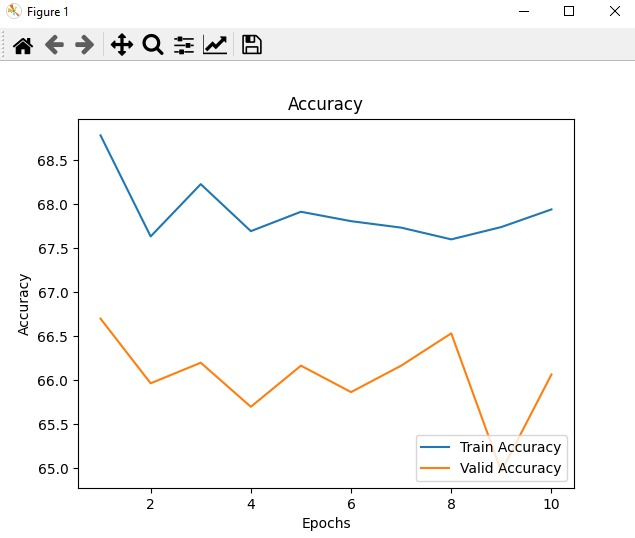

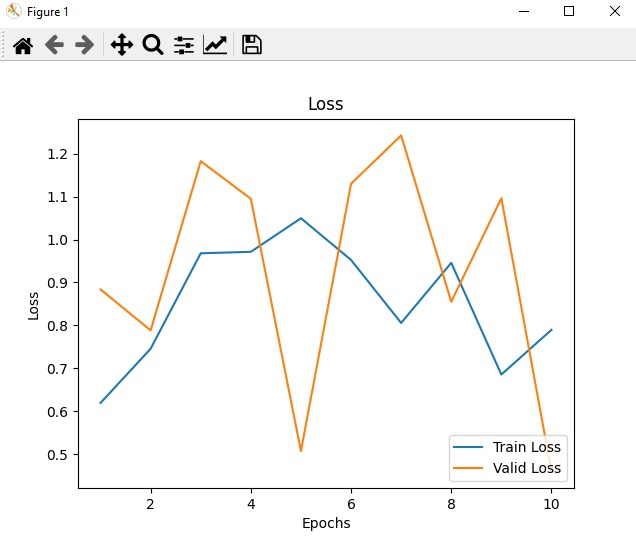

<h2 style="color: firebrick; font-family: verdana"><b>2.2: Finetuning Only the Last Two Layers</b></h2>

<p style="font-family: verdana">First, we'll define another model using the pre-trained VGG-19 CNN and modify the last layer as we did while finetuning all layers of the CNN. Then, we'll freeze all layers and train only the last 2 fully connected layers using the previously-defined model training function. Keep in mind that we'll use the same optimizer, loss function and the learn rate and momentum values with the ones used in 2.1.</p>

In [ ]:
print("####### Fine tune the weights of only two last fully connected (FC1 and FC2) layers #######")

# Modify last layer
model_2 = torchvision.models.vgg19(pretrained=True)
number_features = model_2.classifier[6].in_features
features = list(model_2.classifier.children())[:-1]
features.extend([torch.nn.Linear(number_features, 10)])
model_2.classifier = torch.nn.Sequential(*features)
model_2 = model_2.to(device)
# Freeze all the layers
for param in model_2.parameters():
    param.requires_grad = False
# Just train last 2 fully connected layer
for layer in model_2.classifier[3:]:
    for param in layer.parameters():
        param.requires_grad = True
# As the loss function we used CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss()
# As the optimizer we used SGD
optimizer = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
# Apply training
train_model(model_2, optimizer, criterion, EPOCH_COUNT)
model_2.eval()
# Creating lists to make predict and find precision recall and f1 score
predicted_labels, ground_truth_labels = [], []
for i, (words, labels) in enumerate(test_data_loader):
    words = words.to(device)
    labels = labels.to(dtype=torch.long).to(device)

    # Forward pass
    outputs = model_2(words)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # feedforward tutorial solution
    _, predicted = torch.max(outputs, 1)
    predicted_labels.append(predicted.cpu().detach().numpy())
    ground_truth_labels.append(labels.cpu().detach().numpy())
pred_list = np.concatenate(predicted_labels).ravel().tolist()
truth_list = np.concatenate(ground_truth_labels).ravel().tolist()

# Find the precision score with precision_score, recall score with recall_score, f1score score with f1_score
# We used zero division to prevent any errors and warnings and specify "weighted" the average
prec = precision_score(truth_list, pred_list, zero_division=1, average="weighted")
recall = recall_score(truth_list, pred_list, zero_division=1, average="weighted")
fscore = f1_score(truth_list, pred_list, zero_division=1, average="weighted")
print("Average Precision Value: ", prec)
print("Average Recall Value: ", recall)
print("Average F1 Score Value: ", fscore)

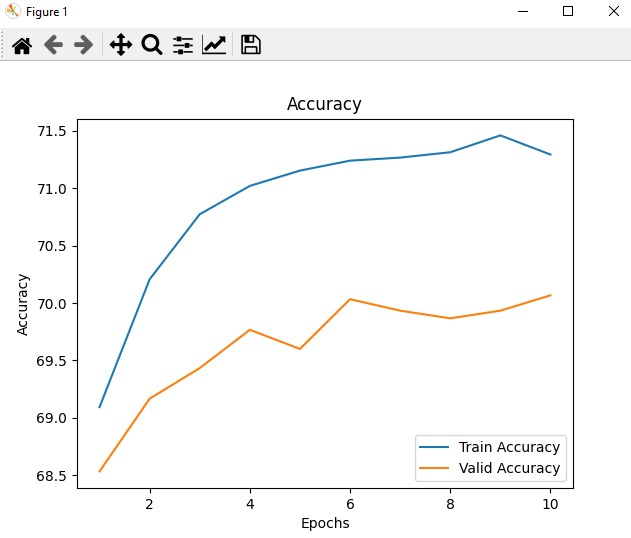

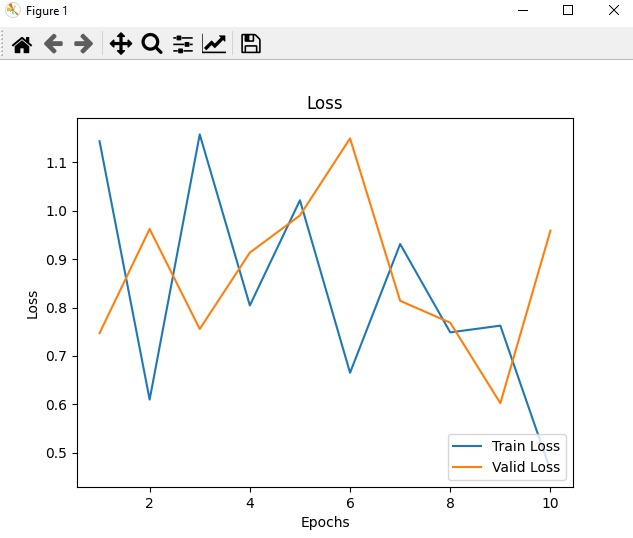

<p style="font-family: verdana">When we compare the findings in 2.2 to the ones in 2.1, we can observe that 2.2's scores were more evenly distributed after finetuning only the two last fully connected layers, opposed to the scores observed when finetuning all layers. We've prevented overfitting by working with a sufficient amount of classes and obtained a healthier result.</p>

<p style="font-family: verdana">In general, the train accuracy turns out to be higher than the validation accuracy and as the epoch increases, the accuracy value increases for both data. As we mentioned before, if we compare 2.1 with 2.2, our accuracy value is 3-4% higher in 2.2. Loss values can also vary, usually between 0.4 and 1.2.</p>

<h2 style="color: firebrick; font-family: verdana"><b>2.3: Visualization of the Results</b></h2>

<p style="font-family: verdana">In this section, we'll first open our image with the Image static object's open() function, present in the Pillow library. After resizing, normalizing and converting our image to a tensor, we'll visualize the weights of the image we picked. In this function we'll also get the number and size of the filters and print them. Then we'll have another function where we'll show the layers of our image one by one. With our image filtering function, we can apply filters to the layers of our image and visualize them.</p>

In [ ]:
################ VISUALIZATION ################
print("Visualization")


def visualize_weights(layer):
    weight = []

    # All convolution layers and append their corresponding filters in a list
    for w in model.features.children():
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            weight.append(w.cpu().weight.data)

    print("Size of Filter:", weight[layer].shape)
    print("Number of Filters:", weight[layer].shape[0])
    filter = []
    for i in range(weight[layer].shape[0]):
        filter.append(weight[layer][i, :, :, :].sum(dim=0))
        filter[i].div(weight[layer].shape[1])
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (15, 15)
    plt.title("Visualization of Weights")
    plt.axis('off')
    for i in range(int(weight[layer].shape[0])):
        fig.add_subplot(int(np.sqrt(weight[layer].shape[0])), int(np.sqrt(weight[layer].shape[0])), i + 1)
        plt.imshow(filter[i])
        plt.axis('off')
    plt.show()


def layer_images(image):
    outputs = []
    names = []

    # Feed forward the image through the network and store the outputs
    for layer in modules:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))

    # Convert the output into a 2D image by averaging across the filters.
    output_im = []
    for temp in outputs:
        temp = temp.squeeze(0)
        temp = torch.sum(temp, dim=0)
        temp = torch.div(temp, temp.shape[0])
        output_im.append(temp.data.numpy())

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (25, 30)
    plt.title("Layers of the Image")
    plt.axis('off')
    for i in range(len(output_im)):
        a = fig.add_subplot(8, 5, i + 1)
        plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(str(i + 1) + ". " + names[i].partition('(')[0], fontsize=8)
    plt.show()


def filter_image(image, layer_to_visualize, num_filters=64):
    output = None
    name = None
    # Take outputs corresponding to the layer
    for count, layer in enumerate(modules):
        image = layer(image)
        if count == layer_to_visualize:
            output = image
            name = str(layer)

    filters = []
    output = output.data.squeeze()

    # Visualize all the filters, if num_filters = -1
    num_filters = min(num_filters, output.shape[0])
    if num_filters == -1:
        num_filters = output.shape[0]

    for i in range(num_filters):
        filters.append(output[i, :, :])

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.title("Applying " + str(num_filters) + " different filters to the " + str(layer_to_visualize + 1) + ". layer")
    plt.axis('off')
    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(int(np.sqrt(len(filters))), int(np.sqrt(len(filters))), i + 1)
        plt.imshow(filters[i])
        plt.axis('off')
    plt.show()


img_raw = Image.open("Vegetable Images/train/Bean/0029.jpg")
plt.imshow(img_raw)
plt.title("Original Image")
plt.axis("off")
plt.show()
# Transform.Compose is used to chain several transforms images together
# We can resize, normalize and convert our images to tensor with Compose
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img = np.array(img_raw)
img = transform(img)
img = img.unsqueeze(0)
modules = list(model.features.modules())
modules = modules[1:]
visualize_weights(1)
layer_images(img)
# Applying 16 filters to [1,8] layers
filter_image(img, 0, 16)
filter_image(img, 1, 16)
filter_image(img, 2, 16)
filter_image(img, 3, 16)
filter_image(img, 4, 16)
filter_image(img, 5, 16)
filter_image(img, 6, 16)
filter_image(img, 7, 16)

print("Process Completed Successfully")

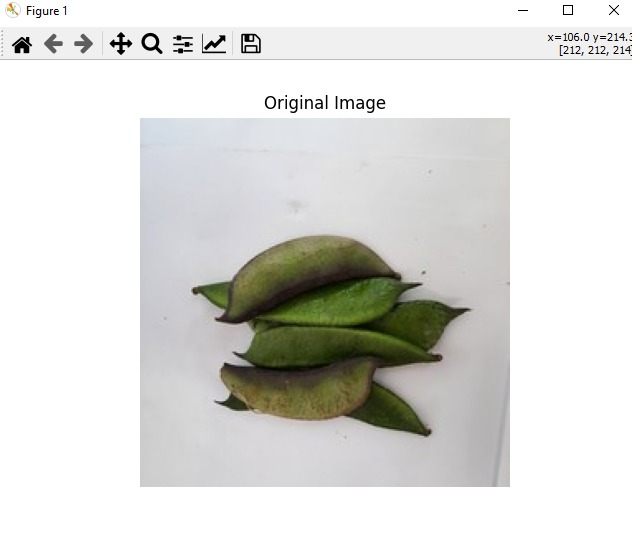

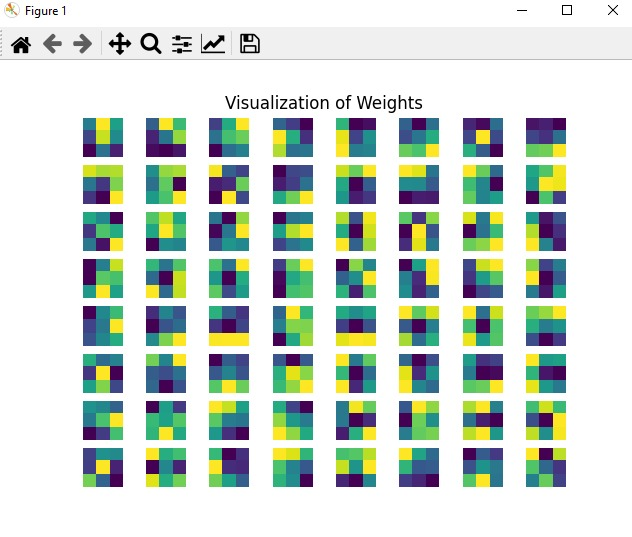

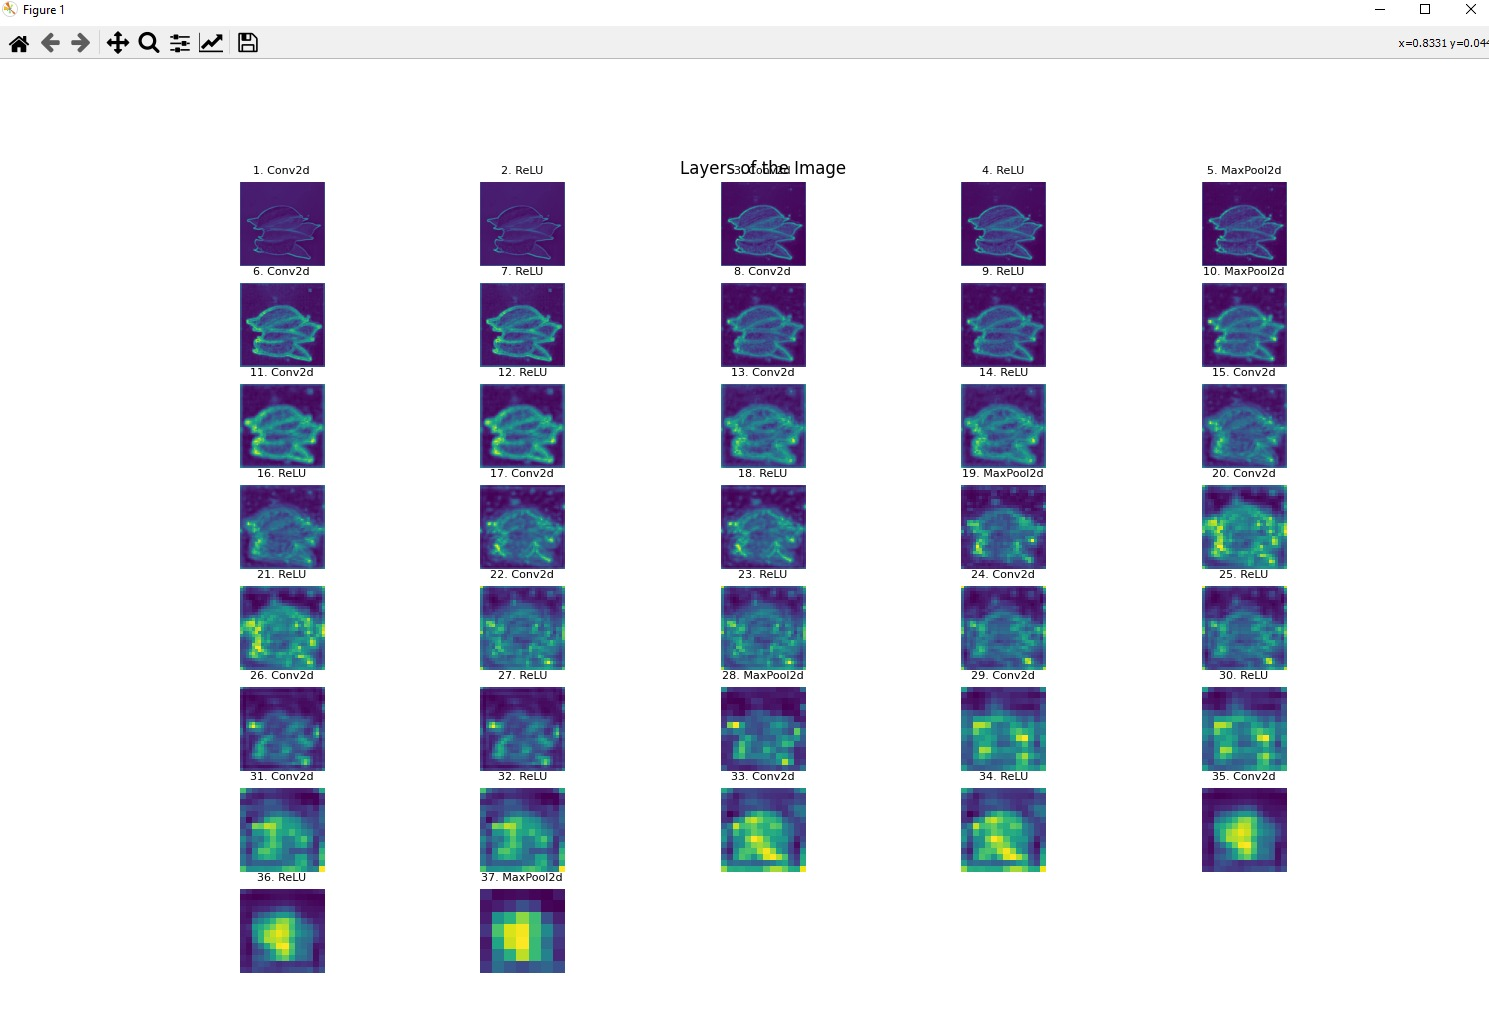

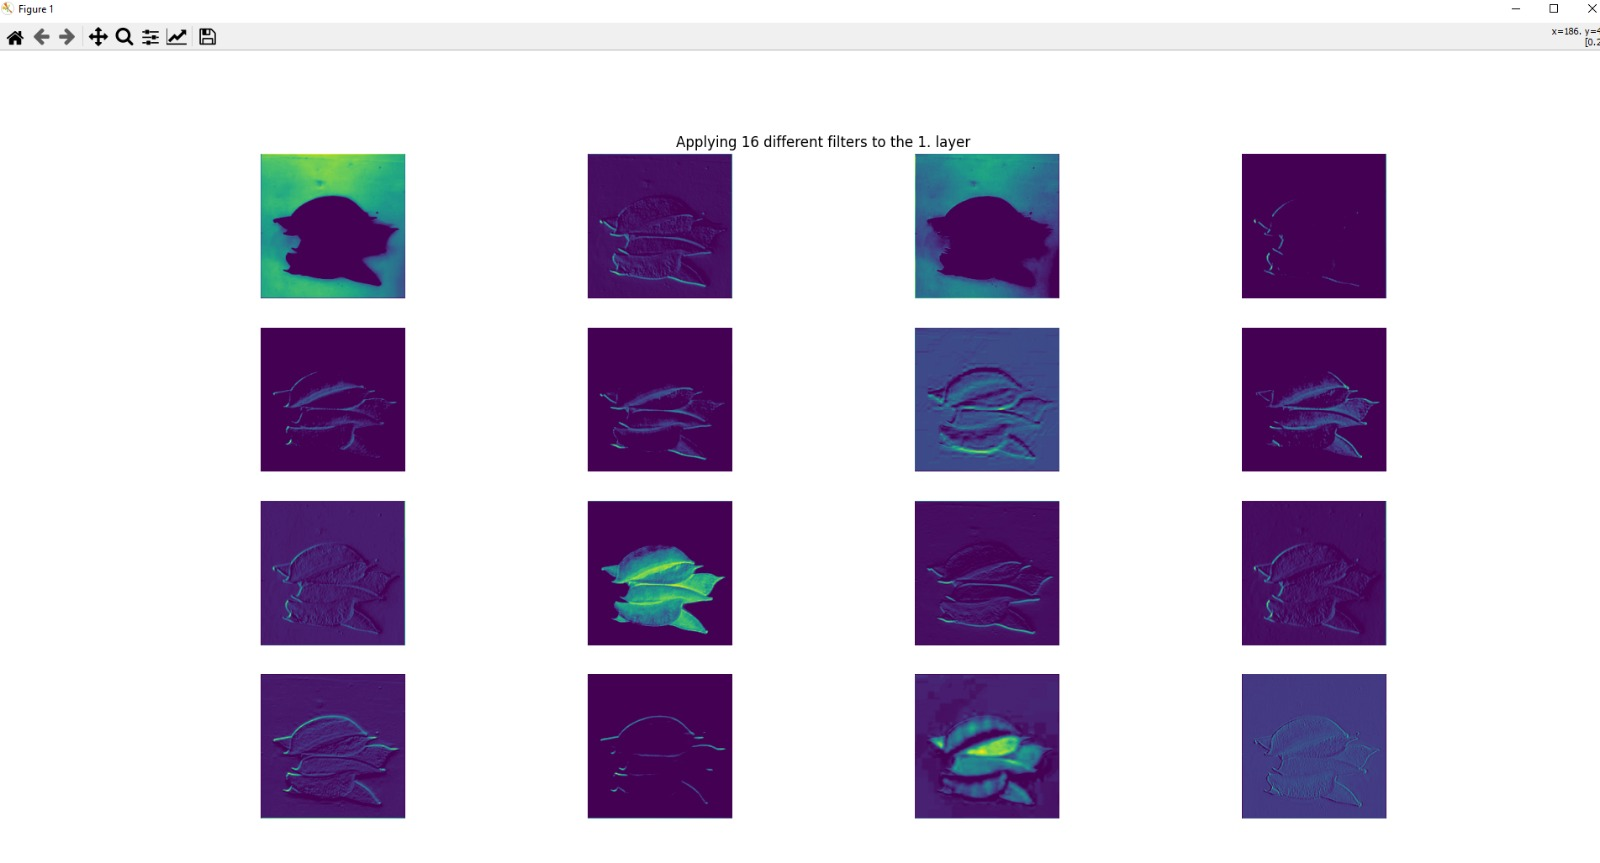

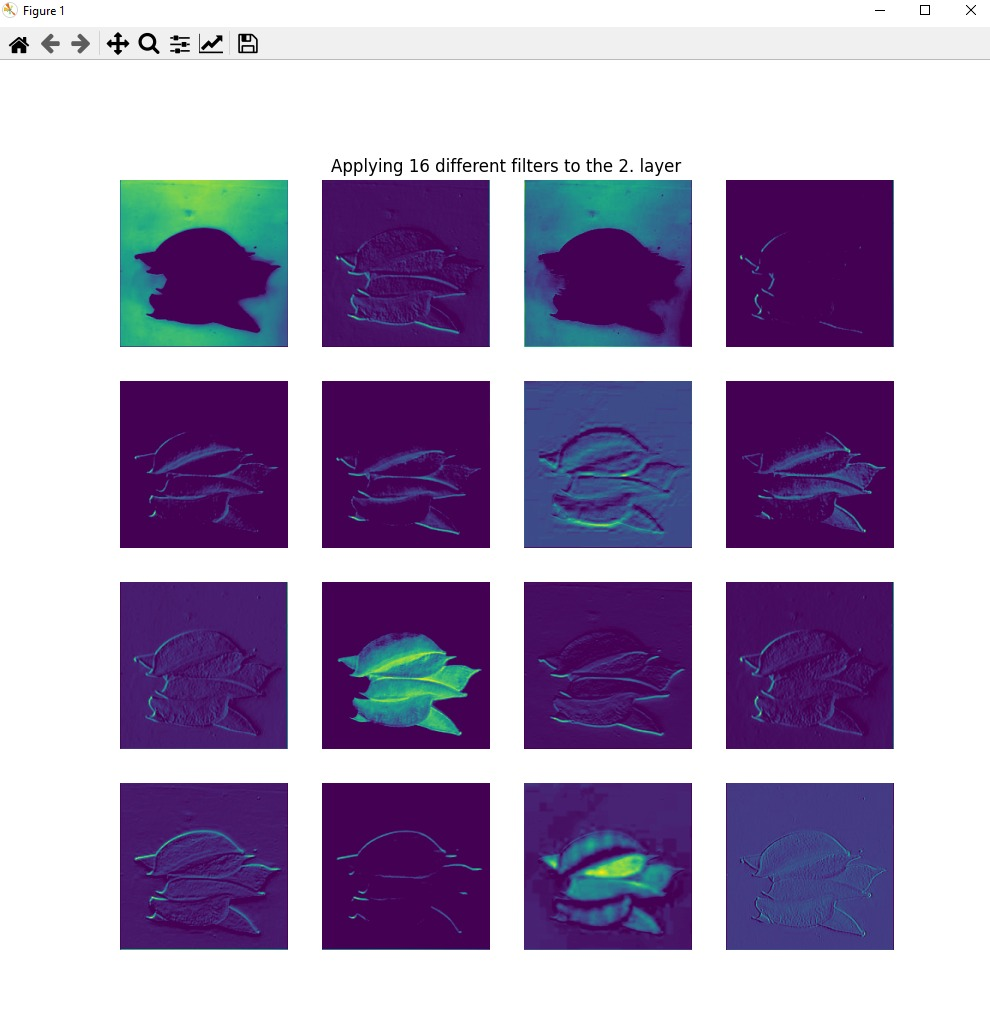

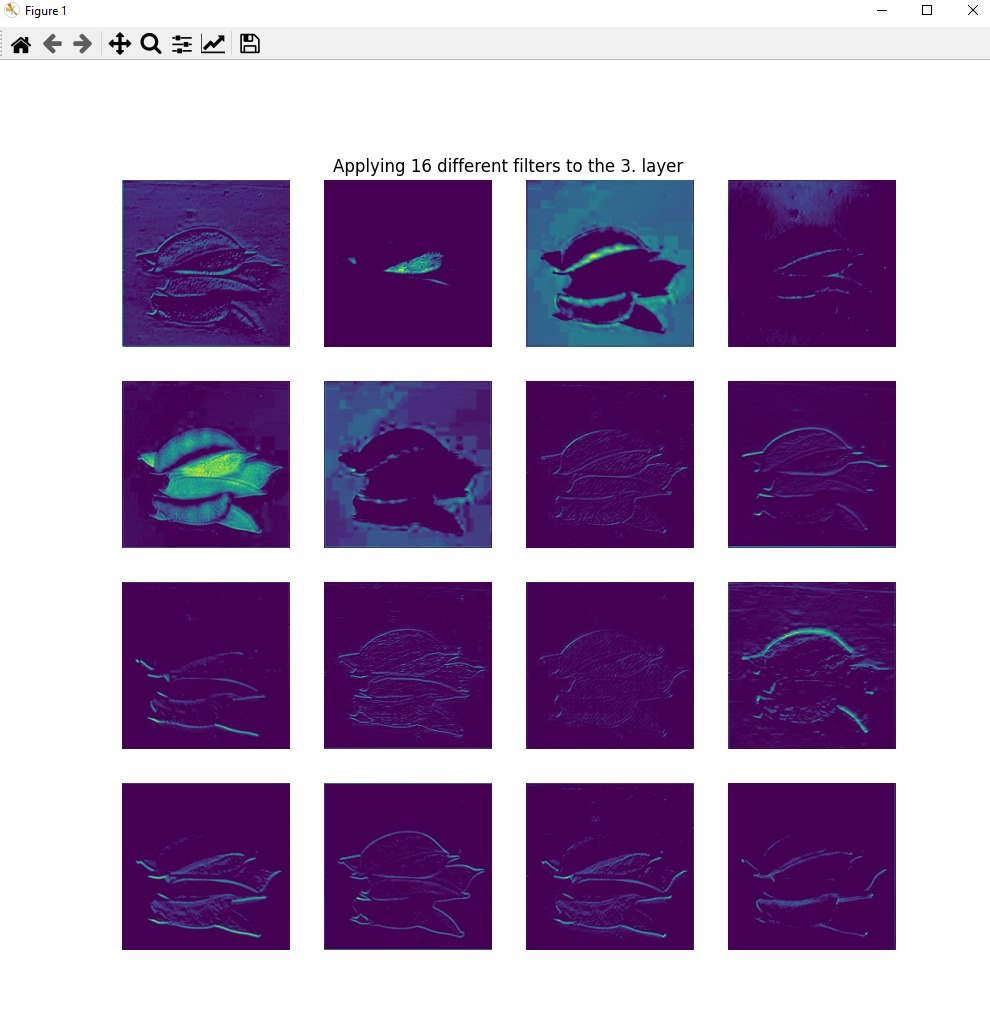

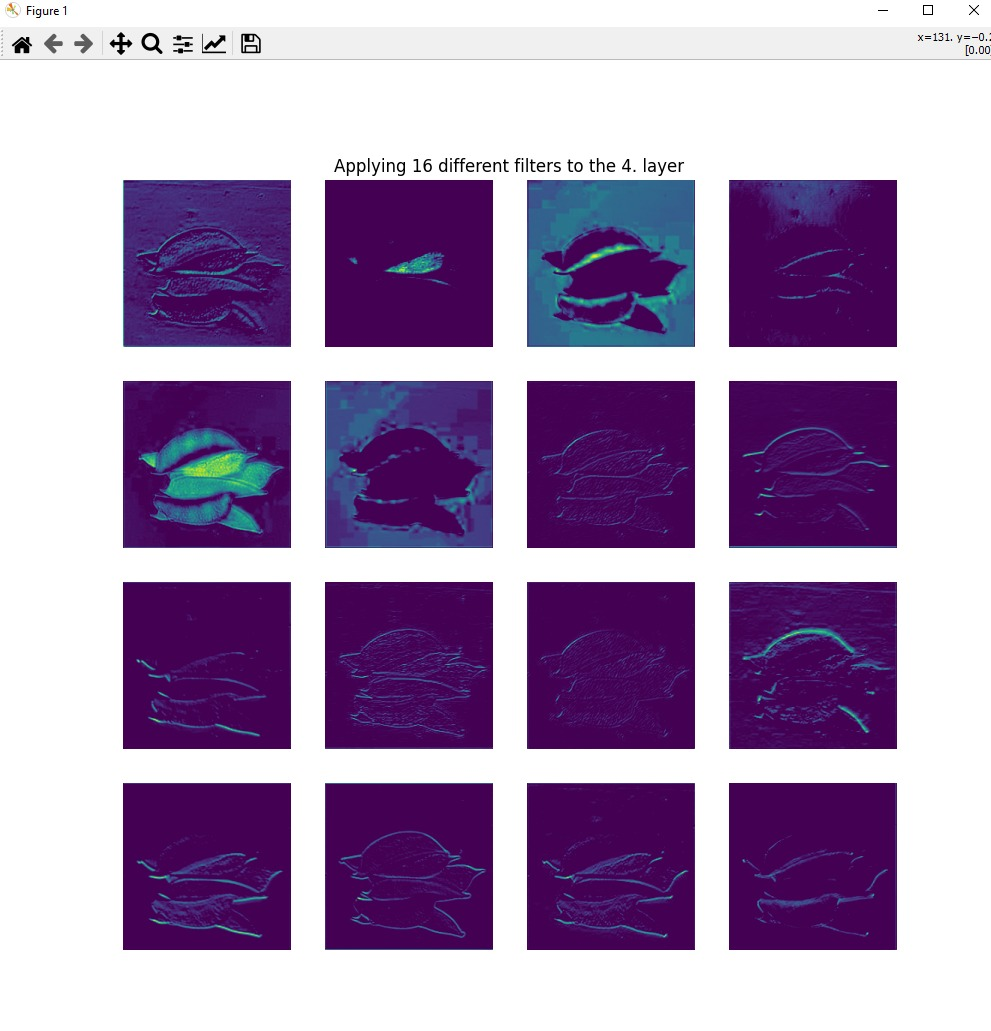

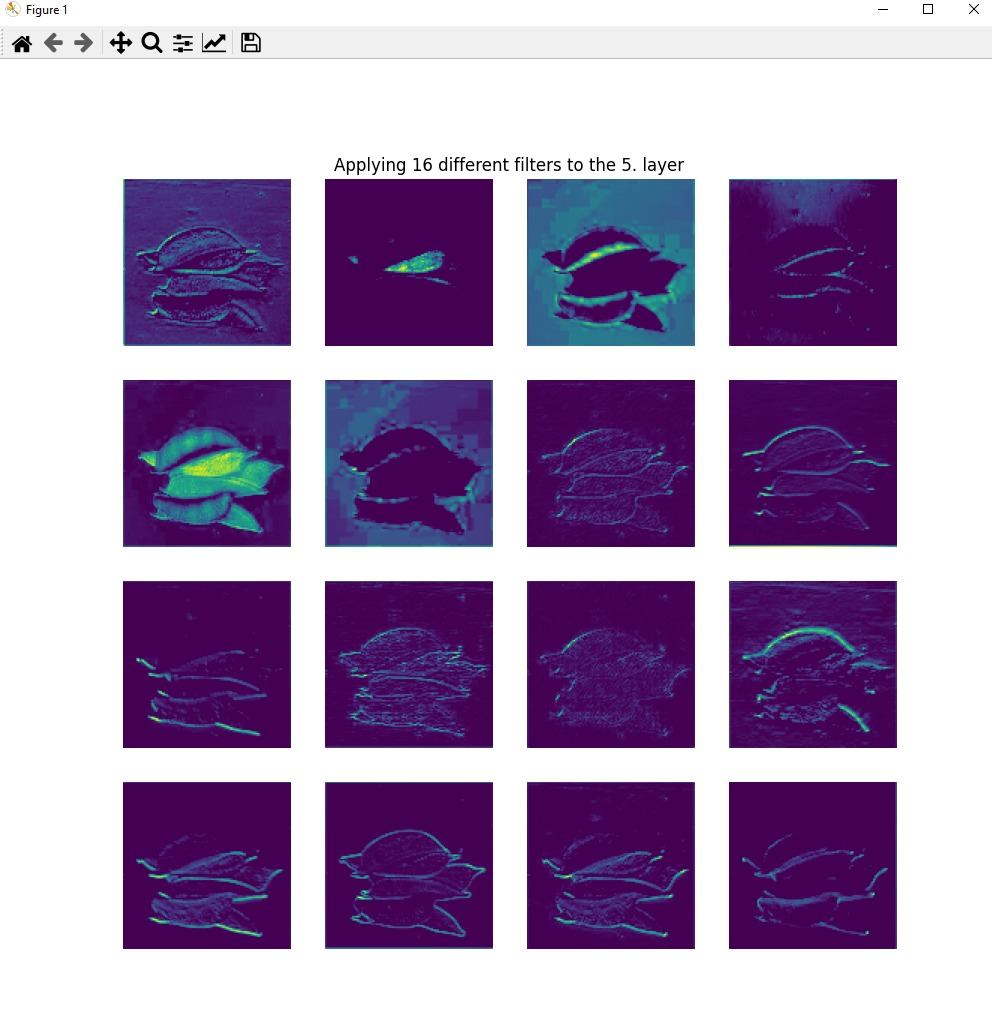

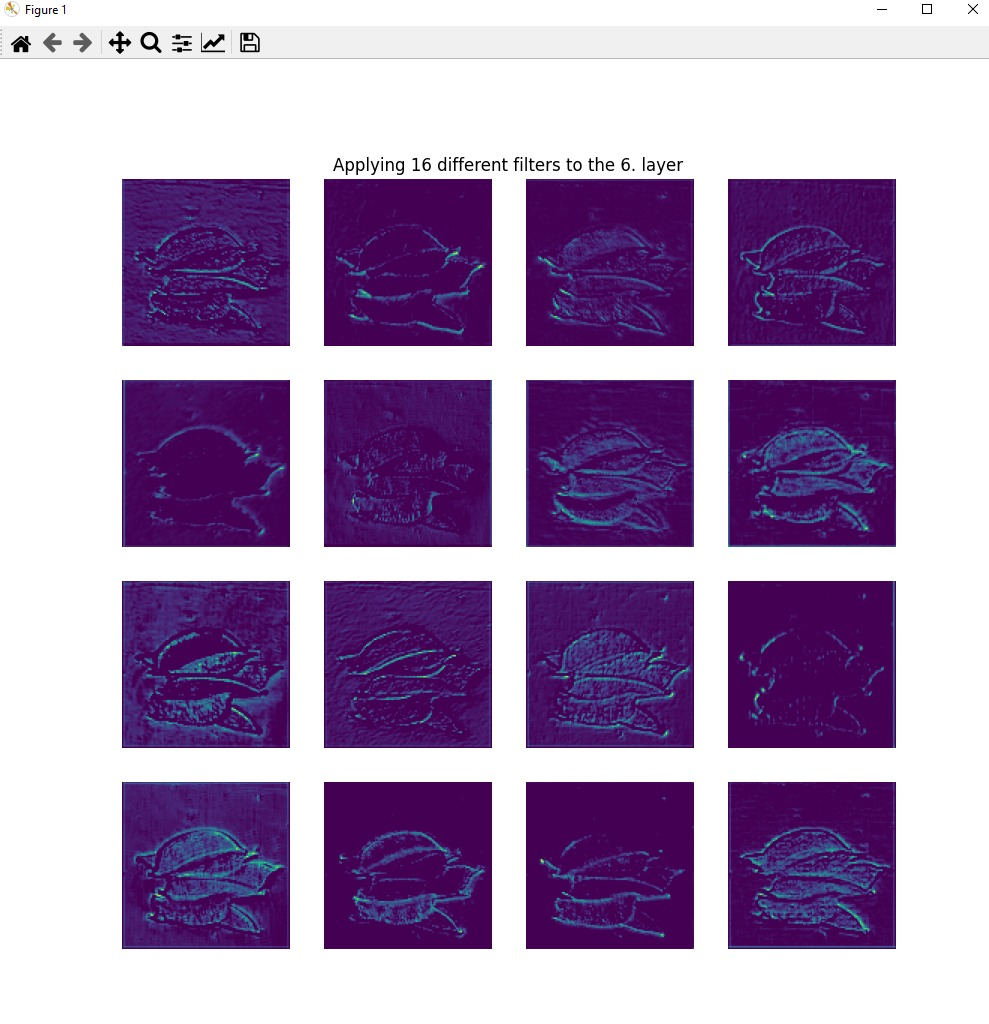

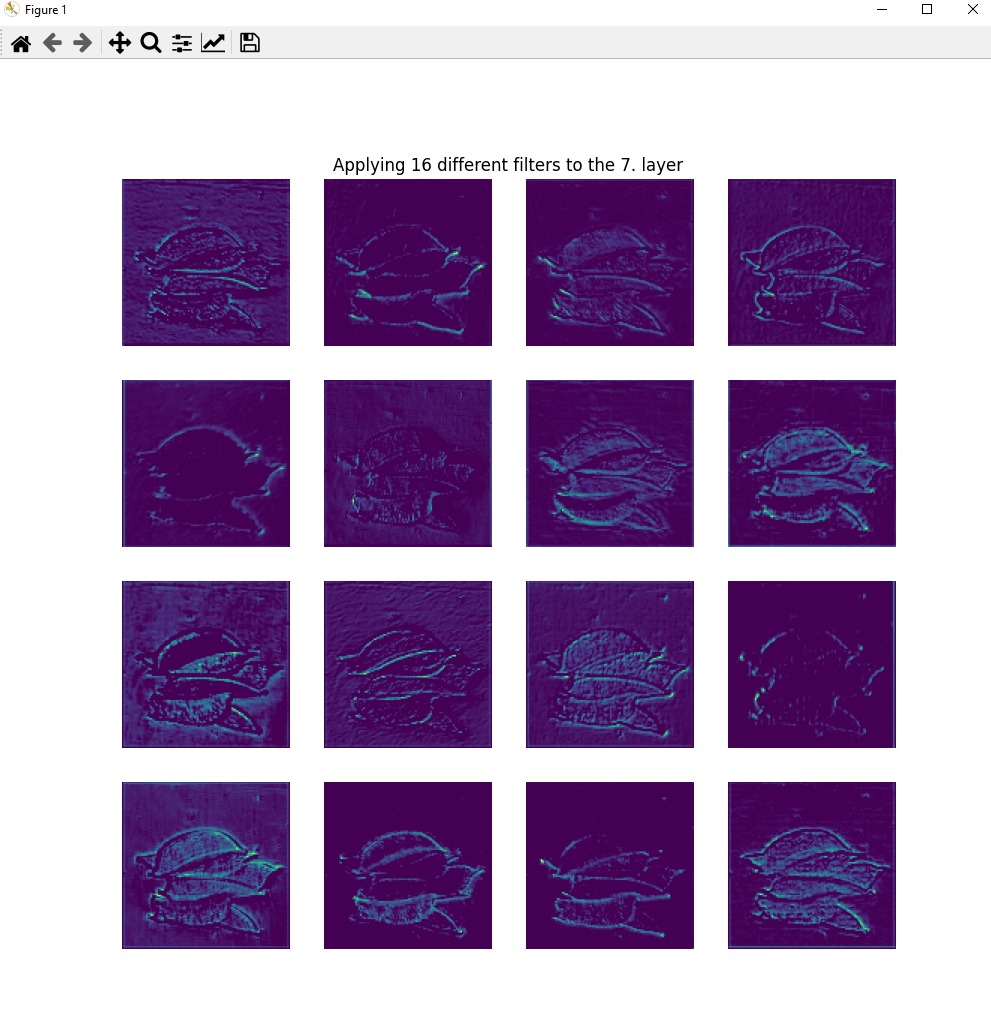

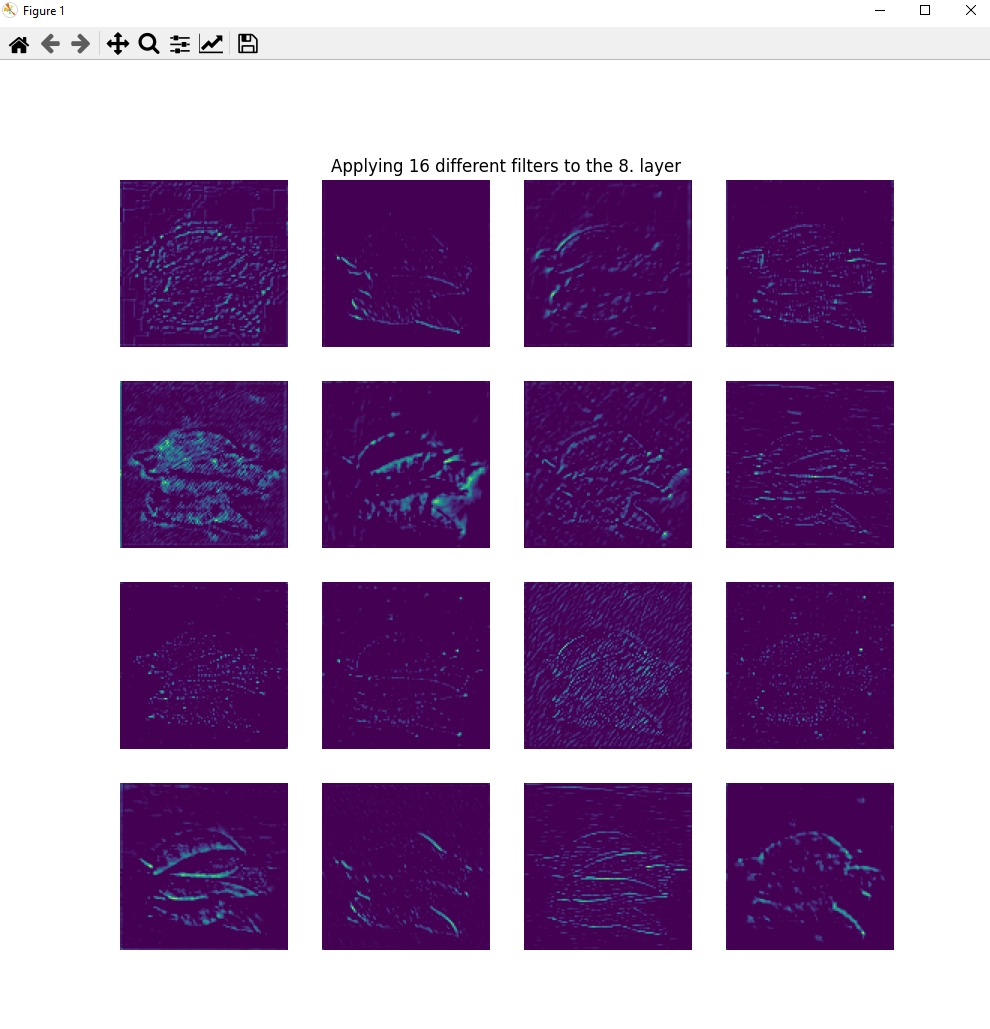